## New York City Airbnb Open Data - NLP

**Vishnu Rangiah, vrrangiah@ucdavis.edu**


We will be exploring the name feature of the Airbnb dataset in depth using NLP techniques. With the use of the popular NLP library **Spacy** we will clean the listing names and extract relevant information such as the most frequnctly used words in listings as well as non english symbols used in the listings. 

In our analysis of the names of the listings we provide visualizations to show the relationship of the name listings across price subgroups and popularity subgroups which we equated to be the number of reviews per month. 

Additionally we explore the unique listing names which contain non english symbols and plot their locations to see if there is any correlation between the language used in the listing and the listing location. This correlation may be present in listing names which contain chinese characters and are potentially located in china town.

**IF TIME PERMITS** We will explore use our data cleaning, visualization, and NLP methods on a 2021 Open Airbnb Data which also have information regarding the listing reviews. We will be able to provide hosts with tools to identify the similar topics and the overall sentiment in the listing's reviews.

### Importing Libraries 

In [1]:
# importing packages

# data manipulation
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.express as px
import geopandas as gpd
import contextily as ctx

# string manipulation
import re
import more_itertools as more
import string

### Loading Dataset

In [3]:
df = pd.read_csv("datasets/AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
# columns and data types
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Here we find that our dataset contains 48,895 rows which represent individual listings in New York. We are also provided with 16 different metrics which contain necessary information about a particular listing.  

### Data Cleaning + Aggregation

In [37]:
# remove null listings
df = df.dropna()

In [6]:
# remove listings that have zero availability (availability_365), zero number_of_reviews, last_review before 2016 
#     and price < $10 or price > $874 

df = df.loc[(df.availability_365 > 0) & (df.number_of_reviews > 0) & (df.last_review > '2016') & 
       (df.price > 10) & (df.price < 874)]

(25693, 16)

In [ ]:
df.shape # size of cleaned dataset 

In [8]:
#Splits data into subsets which are based on quatiles of 'reviews per month' and 'price' metrics

df_r_low = df[df['reviews_per_month'].between(0, 0.45)] #25%
df_r_mid = df[df['reviews_per_month'].between(0.46, 1.23)] #50%
df_r_high = df[df['reviews_per_month'].between(1.24, 2.68)] #75%
df_r_extra = df[df['reviews_per_month'].between(2.69, 70)] #75%

df_p_low = df[df['price'].between(0, 70)] #25%
df_p_mid = df[df['price'].between(70.01, 109)] #50%
df_p_high = df[df['price'].between(109.01, 175)] #75%
df_p_extra = df[df['price'].between(175, 9999)] #100%

In [14]:
df['price'].describe()

count    25693.000000
mean       139.905266
std        109.057525
min         11.000000
25%         69.000000
50%        106.000000
75%        175.000000
max        860.000000
Name: price, dtype: float64

In [15]:
df['reviews_per_month'].describe()

count    25693.000000
mean         1.833355
std          1.808862
min          0.020000
25%          0.470000
50%          1.270000
75%          2.710000
max         58.500000
Name: reviews_per_month, dtype: float64

### Cleaning 'Name' Metric

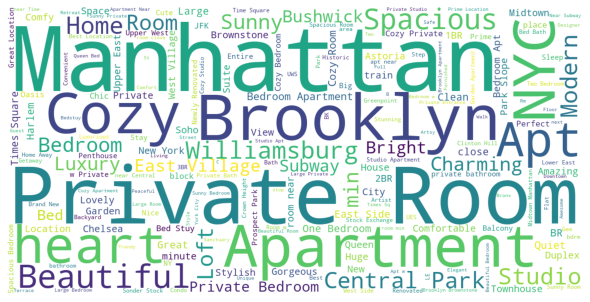

In [36]:
#Word cloud of names directly from the dataframe df
#includes names with punctuation and stopwords
df_nc = df

from wordcloud import WordCloud

corpus = list(df_nc["name"].values)
clean_named = (' '.join(w for w in corpus if isinstance(w, str) ))

wordcloud = WordCloud(width = 1200, height = 600,
                background_color ='white',
                min_font_size = 10).generate(clean_named)

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig("wordcloud.jpg")
plt.show()

An initial analysis of our raw dataframe's listing names shows that the words with the most frequencies are neighborhood and borough names, type of room, and general location indicators. It would make sense that Brooklyn and Manhattan are some of the most frequent words because they are the 2 most popular boroughs as seen in our EDA. We can also infer that hosts use listing names to capitalize on different features of the property, from location indicators such as "heart" and "near", number of bedrooms, and different landmarks and neighborhood names. Additionally, it is interesting to note the many different variations of phrases containing "cozy", such as "cozy room", "cozy bedroom", etc.

In [6]:
#spacy used to clean names columns of punctuations and stop words
from spacy.lang.en import English
import spacy
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

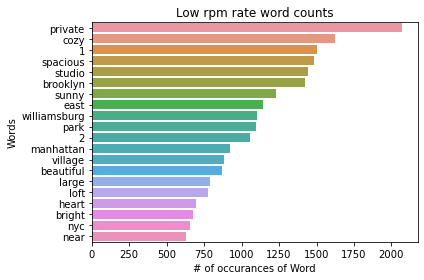

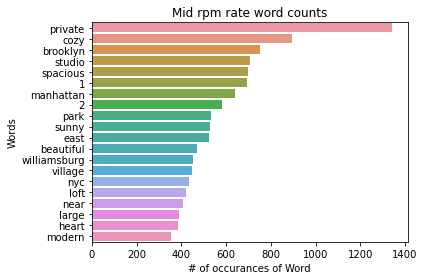

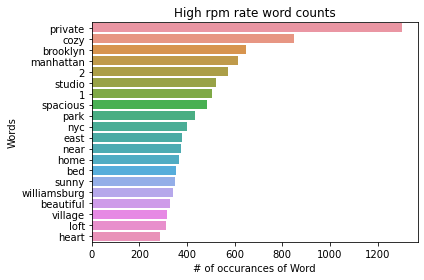

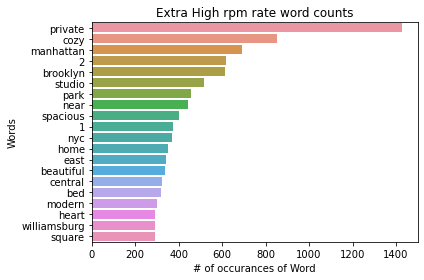

In [12]:
#Reviews per month comparison of word frequencies 

from collections import Counter

dfs = [df_r_low, df_r_mid, df_r_high, df_r_extra] #list of dataframes 

names_c = [] #list to store all the names per subgroup as one big string, should be list length of 4

nlp = English() #spacy tokenizer
nlp.Defaults.stop_words |= {"room", "bedroom", "apartment", "apt"} #added stop words 

for i in dfs: 
    names_low = i["name"].values
    clean_named = (' '.join(str(n).lower() for n in names_low) )
    name = nlp(clean_named) #tokinzed name
    filtered_name = []

    # filtering name from stop words
    for word in name:
        if word.is_stop==False and word.is_punct==False: #takes out punctuation 
            filtered_name.append(word)

    name_clean = ' '.join([str(w).lower() for w in filtered_name])
    names_c.append(name_clean)

def plot_names(names): 
    split_it = names.split()
    counts = Counter(split_it)
    # most_common() produces k frequently encountered
    most_occur = counts.most_common(20)
    most_df = pd.DataFrame(most_occur, columns =['Words', 'Freq'])
    plt.figure()
    sns.barplot(y="Words", x="Freq", data=most_df)
    
namesr = ["Low rpm rate", "Mid rpm rate", "High rpm rate", "Extra High rpm rate"]

#CREATES THE PLOTS
for i in range(0,len(names_c)): 
    plot_names(names_c[i])
    plt.title(namesr[i]+' word counts')
    plt.xlabel("# of occurances of Word")
    plt.tight_layout()
    plt.savefig("fig_review"+str(i)+".jpg")

We observe that listings with higher reviews per month values shows little to no difference in the most used word choice compared to listings in the lower subgroups of reviews per month values. 

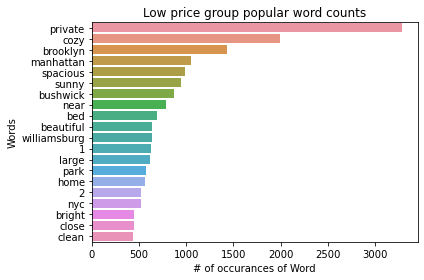

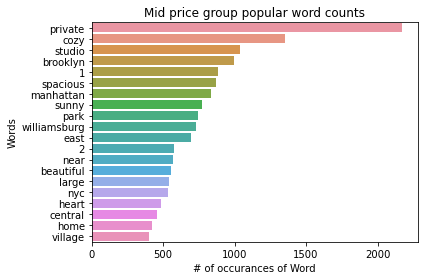

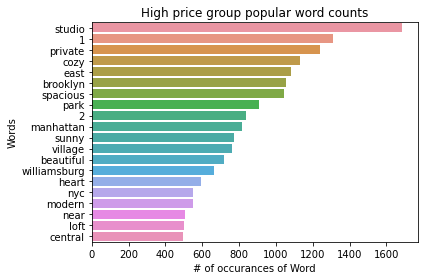

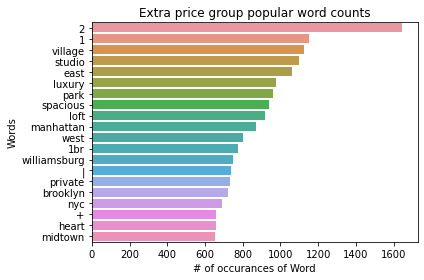

In [13]:
#Price comparison of word frequencies 

dfsp = [df_p_low, df_p_mid, df_p_high, df_p_extra]
names_cp = [] #list of all the names as strings

nlp = English()#spacy tokenizer

for i in dfsp: 
    names_low = i["name"].values
    clean_named = (' '.join(str(n).lower() for n in names_low) )
    name = nlp(clean_named) #tokinzed name
    filtered_name = []

    # filtering name from stop words
    for word in name:
        if word.is_stop==False and word.is_punct==False: #takes out punctuation 
            filtered_name.append(word)

    name_clean = ' '.join([str(w).lower() for w in filtered_name])
    names_cp.append(name_clean)


def plot_names(names): 
    split_it = names.split()
    counts = Counter(split_it)
    # most_common() produces k frequently encountered
    most_occur = counts.most_common(20)
    most_df = pd.DataFrame(most_occur, columns =['Words', 'Freq'])
    plt.figure()
    sns.barplot(y="Words", x="Freq", data=most_df)
    
namesp = ["Low price group", "Mid price group", "High price group", "Extra price group"]


#CREATES THE PLOTS
for i in range(0,len(names_cp)): 
    plot_names(names_cp[i])
    plt.title(namesp[i]+' popular word counts')
    plt.xlabel("# of occurances of Word")
    plt.tight_layout()
    plt.savefig("fig_price"+str(i)+".jpg")

We observe that lower priced listings appear to have key words such as "cozy" and "studio" indicating smaller sq. ft. listings whereas higher priced listings appear to showcase the number of bedrooms in the listings or indicate that the listing is "luxury" and "spacious".

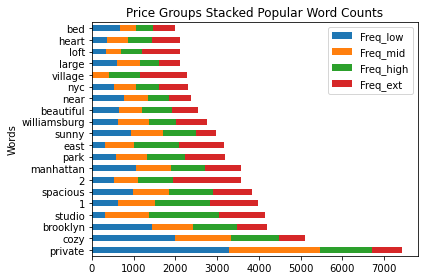

In [14]:
from matplotlib.pyplot import figure

#Price stacked word counts

lowp = names_cp[0].split()
countlowp = Counter(lowp)
countlowp50 = countlowp.most_common(50)
lowpdf = pd.DataFrame(countlowp50, columns =['Words', 'Freq_low'])

midp = names_cp[1].split()
countmidp = Counter(midp) 
countmidp50 = countmidp.most_common(50)
midpdf = pd.DataFrame(countmidp50, columns =['Words', 'Freq_mid'])

highp = names_cp[2].split()
counthighp = Counter(highp)
counthighp50 = counthighp.most_common(50)
highpdf = pd.DataFrame(counthighp50, columns =['Words', 'Freq_high']) 

extp = names_cp[3].split()
countextp = Counter(extp) 
countextp50 = countextp.most_common(50)
extpdf = pd.DataFrame(countextp50, columns =['Words', 'Freq_ext'])

asd1 = pd.merge(lowpdf,midpdf,on='Words',how='outer')
asd2 = pd.merge(asd1,highpdf,on='Words',how='outer')
asd3 = pd.merge(asd2,extpdf,on='Words',how='outer')

finaldf = asd3.fillna(0)
freqsum = finaldf['Freq_low']+finaldf['Freq_mid']+finaldf['Freq_high']+finaldf['Freq_ext']
finaldf['freq_sum'] = freqsum
fianldf = finaldf.sort_values(by=['freq_sum'], inplace=True, ascending=False)
finaldf = finaldf.head(20)
finaldf = finaldf.set_index('Words')
finaldf = finaldf.drop(['freq_sum'], axis=1)

finaldf.plot(kind='barh', stacked=True)
plt.title("Price Groups Stacked Popular Word Counts")
plt.tight_layout()
plt.savefig("pgStack.jpg")

In [39]:
finaldf.head()

,Freq_low,Freq_mid,Freq_high,Freq_ext
Words,,,,
private,2071.0,1344.0,1303.0,1428.0
cozy,1620.0,896.0,850.0,851.0
brooklyn,1426.0,753.0,647.0,611.0
studio,1441.0,708.0,522.0,517.0
1,1500.0,695.0,506.0,375.0


We find from the above graphs and table the most used words in listings names per price subgroup. The word "private" appears to be used most frequently across price groups. 

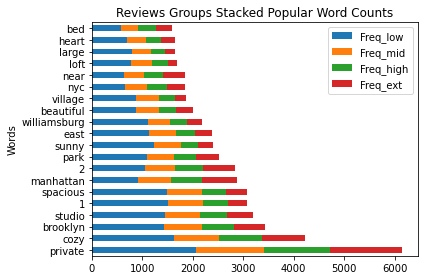

In [16]:
#Reviews stacked word counts 

lowr = names_c[0].split()
countlowr = Counter(lowr)
countlowr50 = countlowr.most_common(50)
lowpdf = pd.DataFrame(countlowr50, columns =['Words', 'Freq_low'])

midr = names_c[1].split()
countmidr = Counter(midr) 
countmidp50 = countmidr.most_common(50)
midpdf = pd.DataFrame(countmidp50, columns =['Words', 'Freq_mid'])

highr = names_c[2].split()
counthighr = Counter(highr)
counthighp50 = counthighr.most_common(50)
highpdf = pd.DataFrame(counthighp50, columns =['Words', 'Freq_high']) 

extr = names_c[3].split()
countextr = Counter(extr) 
countextp50 = countextr.most_common(50)
extpdf = pd.DataFrame(countextp50, columns =['Words', 'Freq_ext'])

asd1 = pd.merge(lowpdf,midpdf,on='Words',how='outer')
asd2 = pd.merge(asd1,highpdf,on='Words',how='outer')
asd3 = pd.merge(asd2,extpdf,on='Words',how='outer')

finaldf = asd3.fillna(0)
freqsum = finaldf['Freq_low']+finaldf['Freq_mid']+finaldf['Freq_high']+finaldf['Freq_ext']
finaldf['freq_sum'] = freqsum
fianldf = finaldf.sort_values(by=['freq_sum'], inplace=True, ascending=False)
finaldf = finaldf.head(20)
finaldf = finaldf.set_index('Words')
finaldf = finaldf.drop(['freq_sum'], axis=1)

finaldf.plot(kind='barh', stacked=True)
plt.title("Reviews Groups Stacked Popular Word Counts")
plt.tight_layout()
plt.savefig("rgStack.jpg")

In [40]:
finaldf.head()

,Freq_low,Freq_mid,Freq_high,Freq_ext
Words,,,,
private,2071.0,1344.0,1303.0,1428.0
cozy,1620.0,896.0,850.0,851.0
brooklyn,1426.0,753.0,647.0,611.0
studio,1441.0,708.0,522.0,517.0
1,1500.0,695.0,506.0,375.0


We find from the above graphs and table the most used words in listings names per review subgroup. The word "private" once again appears to be used most frequently across price groups. 

### Cleaning Listing Names

In [48]:
cleaned_names = []

nlp = English()

for i in list(df["name"].values):
    name = (''.join(str(n).lower() for n in i))
    txt_tokens = nlp(i)
    
    filtered_name = []
    
    for word in txt_tokens:
        if word.is_stop==False and word.is_punct==False: #takes out punctuation 
            filtered_name.append(word)

    name_clean = ' '.join([str(w).lower() for w in filtered_name])
    cleaned_names.append(name_clean)

In [49]:
cleaned_names[0:10]

['clean quiet home park',
 'skylit midtown castle',
 'cozy entire floor brownstone',
 'entire spacious studio loft central park',
 'large cozy 1 br midtown east',
 'blissartsspace',
 "large furnished near b'way",
 'cozy clean guest family',
 'cute cozy lower east 1 bdrm',
 'beautiful 1br upper west']

### Findings Special Characters in Listing Names

In the process of cleaning listing names we were able to observe listings whose names were entered in different languages. We beileve their may be a geographic relationship between the listing names and its location in NYC. We have strong reason to believe this since NYC contains two prominent chinatowns and we have observed many chinese symbols in the listing names.

In [50]:
#Finding non alphabet characters 

specialC = []

#check to see if each name string can be encoded as ASCII characters if it cannot it is considered a special character

for i in list(df["name"].values): 
    a = str(i)
    if a.isascii(): #checks if string is ASCII 
        continue
    else: 
        specialC.append(i)
  
len(specialC)

954

In [52]:
specialC[0:20]

['Williamsburg—Steps To Subway, Private Bath&Balcony',
 'NYC artists’ loft with roof deck',
 'The Institute—Heart of Williamsburg',
 'Private Garden Apt • New Renovation',
 'Eveland the Place to Stay & Enjoy a 5-⭐️ 2bdrm',
 'Beautiful, Bright’s, Warm & Spacious 1.5BR Apt',
 "⚡Quiet Gem w/roof deck on NY's Hottest Street⚡",
 '☆Massive DUPLEX☆ 2BR & 2BTH East Village 9+ Guests',
 '☆ STUDIO East Village ☆ Own bath! ☆ Sleeps 4 ☆',
 'Lovely Vintage Haven—Heart of UWS',
 '✿✿✿ COUNTRY COTTAGE IN THE CITY✿✿✿',
 '✿✿✿ COUNTRY COTTAGE IN THE CITY✿✿✿',
 'Newly Reno’d Chic Quiet Exec 1BR',
 'Lovely pied-à-terre, in an historic building',
 'Large & bright 900ft² 1br in WV',
 'Zen Eyrie –Airport Pick-Up: JFK/LGA',
 'ingefära hus! Private room Williamsburg, Brooklyn',
 'LUXE Privé L.I.C. Apt & Garden',
 'Private Artist’s Apt/ Amazing Location!',
 'UNION SQUARE❤️PENTHOUSE 2FL+TERRACE❤️EAST VIllAGE']

In [53]:
import re

eastasian = []

def isEA(s):
    s = str(s)
    if len(re.findall(r'[\u4e00-\u9fff]+', s))>0: #Checks if string matches with any of the east asian unicodes
        return True
    return False

for i in specialC: 
    a = str(i)
    if isEA(a): eastasian.append(i)

len(eastasian)

196

In [55]:
from emoji import UNICODE_EMOJI

emojiLists = []

def is_emoji(s):
    s = str(s)
    count = 0
    for emoji in UNICODE_EMOJI: #Checks if string matches with any of the emoji unicodes provided by the UNICODE EMOJI package
        count += s.count(emoji)
        if count > 1:
            return False
    return bool(count)

for i in specialC: 
    a = str(i)
    if is_emoji(a): emojiLists.append(i)

len(emojiLists)

257

In [56]:
eastasian_index = []
emoji_index = []

#Creates logical index lists which iterate through the list of names to check if a name contains an emoji or east asian characters
#We create two logical index lists using for loops 

for i in list(df["name"].values): 
    a = str(i)
    if is_emoji(a) and not a.isascii() : #must be contain an emoji
        emoji_index.append(True)
    else: 
        emoji_index.append(False)


for i in list(df["name"].values): 
    a = str(i)
    if isEA(a) and not a.isascii() : #must be contain an east asian symbols
        eastasian_index.append(True)
    else: 
        eastasian_index.append(False)

df_eastasian = df[eastasian_index]
df_emoji = df[emoji_index]

Text(0.5, 1.0, 'Density Map of Listings with Emojis')

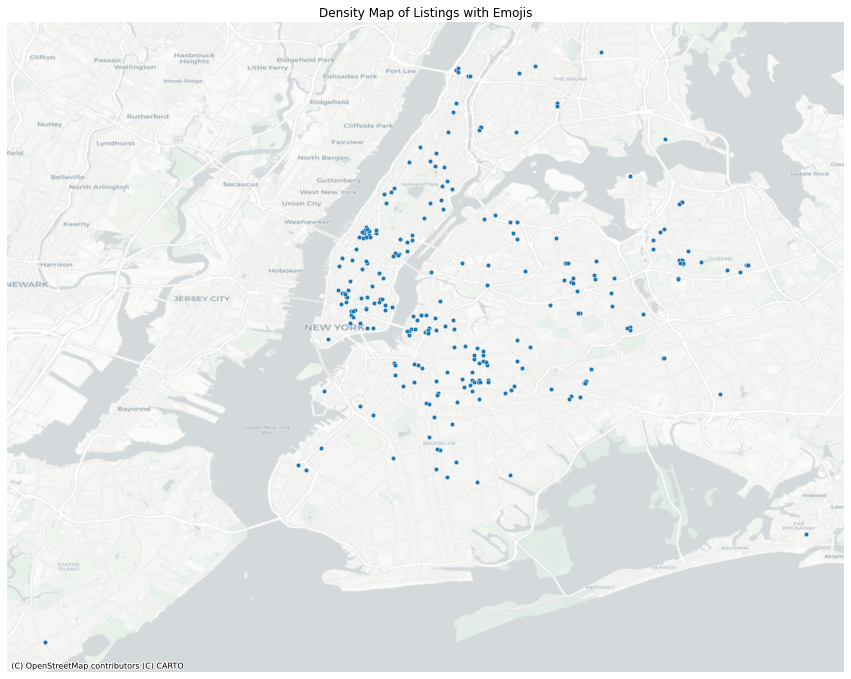

In [58]:
plt.figure(figsize=(15,30))
sns_map_emoji = sns.scatterplot(x='longitude', y='latitude',s=20, data=df_emoji)
ctx.add_basemap(sns_map_emoji, crs = 'EPSG:4326', source=ctx.providers.CartoDB.Positron)
sns_map_emoji.set_axis_off()
plt.title('Density Map of Listings with Emojis')

Unlike non-English listings, there doesn’t seem to be a geographical correlation between listing names with emojis, apart from a slight clustering in Hell’s Kitchen. Further analysis of the Hell’s Kitchen listings show that this is purely coincidental, as there aren’t any 343 single hosts with multiple emoji listings in Hell’s Kitchen driving up the concentration apart from Louis (Host ID: 209405908) with 2 listings in Hell’s Kitchen.

Text(0.5, 1.0, 'Density Map of East Asian Language Listings')

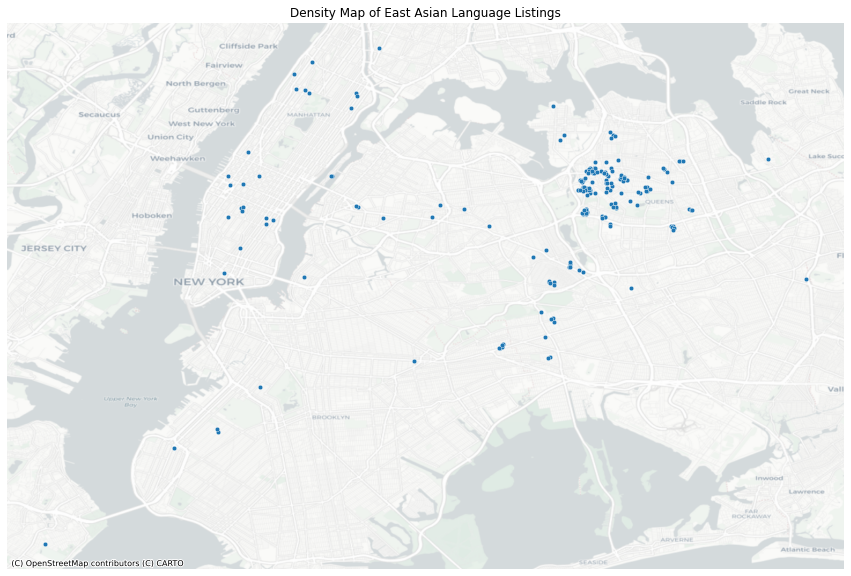

In [57]:
plt.figure(figsize=(15,30))
sns_map_noneng = sns.scatterplot(x='longitude', y='latitude',s=20, data=df_eastasian)
ctx.add_basemap(sns_map_noneng, crs = 'EPSG:4326', source=ctx.providers.CartoDB.Positron)
sns_map_noneng.set_axis_off()
plt.title('Density Map of East Asian Language Listings')

From the density map and bar charts, we can clearly see a concentration of non-English listings in Flushing, Queens. This confirms our hypothesis that many of these non-English listings are geographically correlated to areas with large populations of specific East Asian cultural groups, in this case, the Chinese community in Flushing Chinatown.

Through NLP, we gained further insight of how Airbnb hosts word their listing names to appeal to customers. Many hosts include technical terms that state the layout of their properties, geographical indicators of proximity, and positive descriptors invoking homeyness. Additionally, these word choices change according to how expensive their listings are. Hosts with non-English listing names, such as Chinese and other East Asian languages, attempt to appeal to corresponding cultural groups based on the cultural demographic of the listings’ geographic location. However, there does not seem to be any immediate correlation between the use of emojis and other non-ASCII characters with geography and other variables.

## Other research questions:

Predicting Airbnb Listing Prices with separate features and past data?

Is there a way to find the most optimal listing for a trip?

Predict which real estate property to buy using real estate and airbnb data to find a property that will bring in the most profit?

## PART 2: Topic Modeling and Sentiment Analysis

*This section is still yet to be finalized and completed*

### Import Libraries 

In [3]:
import pandas as pd

### Load Datasets

#### The datasets are imported from - http://insideairbnb.com/get-the-data.html

1. 02 June, 2021 	New York City 	**listings.csv.gz** 	Detailed Listings data for New York City
2. 02 June, 2021 	New York City 	**calendar.csv.gz** 	Detailed Calendar Data for listings in New York City
3. 02 June, 2021 	New York City 	**reviews.csv.gz** 	    Detailed Review Data for listings in New York City
4. 02 June, 2021 	New York City 	**listings.csv** 	    Summary information and metrics for listings in New York City   (good for visualisations).
5. 02 June, 2021 	New York City 	**reviews.csv** 	    Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).

In [5]:
pwd

'C:\\Users\\Ramesh\\Airbnb-Open-Data'

In [6]:
listings = pd.read_csv('datasets/listings.csv')
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,48,2019-11-04,0.34,3,308
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...",4869,LisaRoxanne,Brooklyn,Bedford-Stuyvesant,40.68494,-73.95765,Entire home/apt,79,1,403,2021-05-04,5.16,1,208
2,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2016-06-05,0.56,1,365
3,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,175,21,1,2014-01-02,0.01,1,134
4,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,61,2,474,2020-09-25,3.61,1,246


In [10]:
#listings_d = pd.read_csv('datasets/listings_d.csv')
#listings_d.head()

In [4]:
for i in listings_d.columns:
    print(i)

id
listing_url
scrape_id
last_scraped
name
description
neighborhood_overview
picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
latitude
longitude
property_type
room_type
accommodates
bathrooms
bathrooms_text
bedrooms
beds
amenities
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
first_review
last_review
review_scores_rating
review_scores_accuracy
review_sc

In [9]:
reviews = pd.read_csv('datasets/reviews.csv')
reviews.head()

,listing_id,date
0,2595,2009-11-21
1,2595,2009-12-05
2,2595,2009-12-10
3,2595,2010-04-09
4,2595,2010-05-25


In [7]:
reviews_d = pd.read_csv('reviews_d.csv')

reviews_d

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...
5,2595,1238204,2012-05-07,1783688,Sergey,Hi to everyone!\r\nWould say our greatest comp...
6,2595,1293632,2012-05-17,1870771,Loïc,"Jennifer was very friendly and helpful, and he..."
7,2595,2022498,2012-08-18,2124102,Melanie,This apartment is like a real castle old and u...
8,2595,4682989,2013-05-20,496053,Eric,Jennifer's place was in a great midtown locati...
9,2595,13193832,2014-05-21,13685934,Gerald,Jennifer is a very nice host. Everything is cl...


**Outline of Project**

- Basic Analysis on the Data Sets
- Use NLP techniques on Airbnb listing, reviews, etc. 
- topic modeling 
- sentiment analysis 
- what else could you do?
    - pytorch 
    - Nvidia GPU
- Understand why to do all of this, why would the text give you new results over the traditional analysis is there something similar, how will this information help the listing owners ? 
- What would the implications to Airbnb be?

#### Inspiration

*What are the kinds of things people talk about in the reviews? Is there anything in common?*

In [8]:
reviews_d.comments

0    Notre séjour de trois nuits.\r\nNous avons app...
1                                    Great experience.
2    I've stayed with my friend at the Midtown Cast...
3    We've been staying here for about 9 nights, en...
4    We had a wonderful stay at Jennifer's charming...
5    Hi to everyone!\r\nWould say our greatest comp...
6    Jennifer was very friendly and helpful, and he...
7    This apartment is like a real castle old and u...
8    Jennifer's place was in a great midtown locati...
9    Jennifer is a very nice host. Everything is cl...
Name: comments, dtype: object

*Per listing what is the overall sentiment of the reviews?*

- put this into a metric 
- find nlp analysis that was done on kaggle 
- can we find something to improve

**Word Clouds**

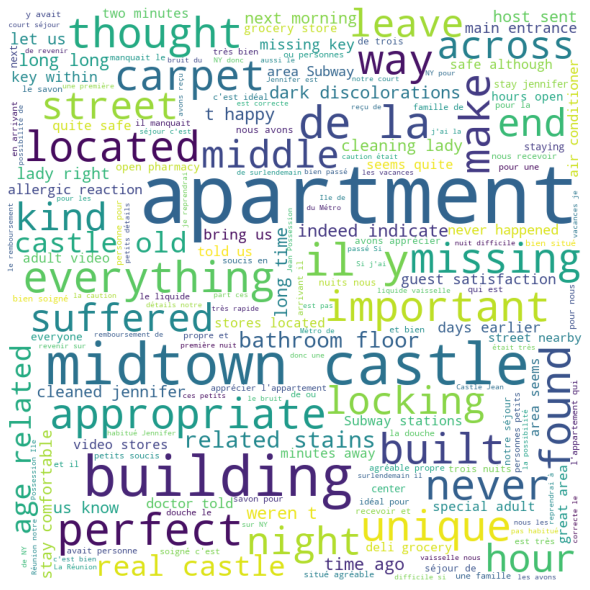

In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in reviews_d.comments:

# typecaste each val to string
    val = str(val)

# split the value
    tokens = val.split()

# Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
